Show the ROC curves for the various classifiers on frb's

In [1]:
from __future__ import division
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append("src")

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn.covariance import EllipticEnvelope

from IsolationClassifier import IsolationTreeClassifier, IsolationRatioClassifier
from pca_frb import PCA_Classifier
from OneClassSVMClassifier import OneClassSVMClassifier
from SemiSupervisedClassifier import SemiSupervisedClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.svm import SVC

from matplotlib.cm import get_cmap
#In a slightly hacky way, add a 'predict_proba' method to the IsolationTree classes
#it doesn't return a probability, but it allows us to call the same method on all the classifiers 

def decision_function(self, X):
    return self.predict_proba(X)[:,1] #prob scores for class 1 

DecisionTreeClassifier.decision_function = decision_function 
MLPClassifier.decision_function = decision_function
GaussianNB.decision_function = decision_function
RandomForestClassifier.decision_function = decision_function
AdaBoostClassifier.decision_function = decision_function
SVC.decision_function = decision_function

classifiers = []

classifiers.append(("CART tree", DecisionTreeClassifier()))
classifiers.append(("MLP", Pipeline([('scaler', StandardScaler()), ('mlp',MLPClassifier())])))
classifiers.append(("Naive Bayes", GaussianNB()))
#classifiers.append(("SVM", Pipeline([('scaler', StandardScaler()),
#                                 ('svc',SVC(class_weight ='balanced', probability=True))])))
#classifiers.append(("Linear SVM", Pipeline([('scaler', StandardScaler()),
 #                                           ('svc',LinearSVC(class_weight ='balanced'))])))
classifiers.append(("Random Forest", RandomForestClassifier()))
classifiers.append(("AdaBoost", AdaBoostClassifier()))
classifiers.append(("Isolation Forest", IsolationTreeClassifier(max_samples=8000)))

unsupervised_classifiers = []
unsupervised_classifiers.append(("Isolation Forest", IsolationTreeClassifier(max_samples=8000)))
unsupervised_classifiers.append(("PCA Log Likelihood", 
                    Pipeline([('scaler', StandardScaler()), ('pca', PCA_Classifier(n_components = 2))])))
unsupervised_classifiers.append(("One Class SVM", Pipeline([('scaler', StandardScaler()), 
                                              ('svm',OneClassSVMClassifier(nu=0.01))])))
unsupervised_classifiers.append(("Elliptic Envelope", EllipticEnvelope()))

generate final plots: leave the stuff below for posterity

In [2]:
from scipy import interp 

def mean_roc_curve(clf, X, Y, axes, n_folds = 5, color = 'k', legend = "", stratified = True):
    """
    See the example at 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    """
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    cv = StratifiedKFold(n_splits = n_folds, shuffle = True) if stratified else KFold(n_splits = n_folds, shuffle = True)
    roc_scores = np.zeros(n_folds)
    roc_curves = []
    i = 0
    for train_inds, test_inds in cv.split(X,Y):
        train_x = X[train_inds]
        train_y = Y[train_inds]
        test_x  = X[test_inds]
        test_y  = Y[test_inds]
        
        
        #print class ratio 
        
        clf.fit(train_x, train_y)
        scores = clf.decision_function(test_x)
        fpr, tpr, thresholds = roc_curve(test_y, scores, pos_label = 1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        roc_scores[i] = roc_auc_score(test_y, scores)
        i+=1
        
    mean_tpr /= n_folds     
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0
    axes.plot(mean_fpr, mean_tpr, color = color, label = legend)
    return roc_scores.mean(), roc_scores.std(ddof = 1)

def mean_PR_curve(clf, X,Y, axes, n_folds=5, color = 'k', legend = "", stratified = True):
    #mean_pr = 0.0
    #mean_rc = np.linspace(0, 1, 100)
    cv = StratifiedKFold(n_splits = n_folds, shuffle = True) if stratified else KFold(n_splits = n_folds, shuffle = True)
    PR_scores = np.zeros(n_folds)
    i = 0
    all_scores = []
    all_ys = []
    for train_inds, test_inds in cv.split(X,Y):
        train_x = X[train_inds]
        train_y = Y[train_inds]
        test_x  = X[test_inds]
        test_y  = Y[test_inds]
        
        
        #print class ratio 
        
        clf.fit(train_x, train_y)
        scores = clf.decision_function(test_x)
        pr, rc, thresholds = precision_recall_curve(test_y, scores)
        all_scores.append(scores)
        all_ys.append(test_y)
        PR_scores[i] = average_precision_score(test_y, scores)
        i+=1
    
    mean_pr, mean_rc, _ = precision_recall_curve(np.concatenate(all_ys), np.concatenate(all_scores))
    axes.plot(mean_rc, mean_pr, color = color, label = legend)

    return PR_scores.mean(), PR_scores.std(ddof = 1)

    
    

In [3]:
with open("frb_datasets/all_data_snr_w_dm.dat") as f:
    dat = [[float(field) for field in line.strip().split(' ')] for line in f]
data = np.array(dat)
X = data[:,:-1] #rm class
Y = data[:,-1]

Isolation Forest ROC Score: 0.988114321689 +/- 0.00819126549006
PCA Log Likelihood ROC Score: 0.969239214471 +/- 0.0151095465992
One Class SVM ROC Score: 0.899727444006 +/- 0.0672660147075
Elliptic Envelope ROC Score: 0.0566118863612 +/- 0.00390408085011


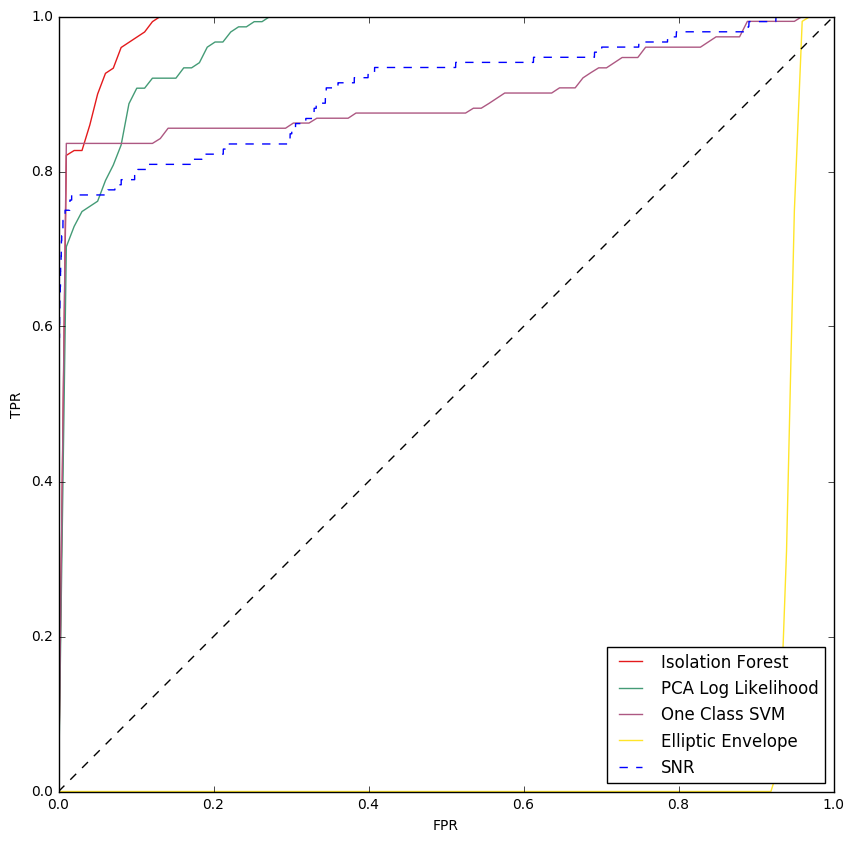

In [8]:
plt.rcParams['figure.figsize'] = 10,10

f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(unsupervised_classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')

#add the line for just using an SNR cutoff 
snr = X[:,0]
fpr, tpr, thresholds = roc_curve(Y, snr, pos_label = 1)
ax.plot(fpr,tpr, linestyle = '--', color = 'blue', label = 'SNR')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

CART tree ROC Score: 0.848172792627 +/- 0.0366185671592
MLP ROC Score: 0.996832533607 +/- 0.00565157684319
Naive Bayes ROC Score: 0.993842995354 +/- 0.00303213716523
Random Forest ROC Score: 0.911045473067 +/- 0.0718697212885
AdaBoost ROC Score: 0.991250828785 +/- 0.0180214703471
Isolation Forest ROC Score: 0.989416234246 +/- 0.00777600414596


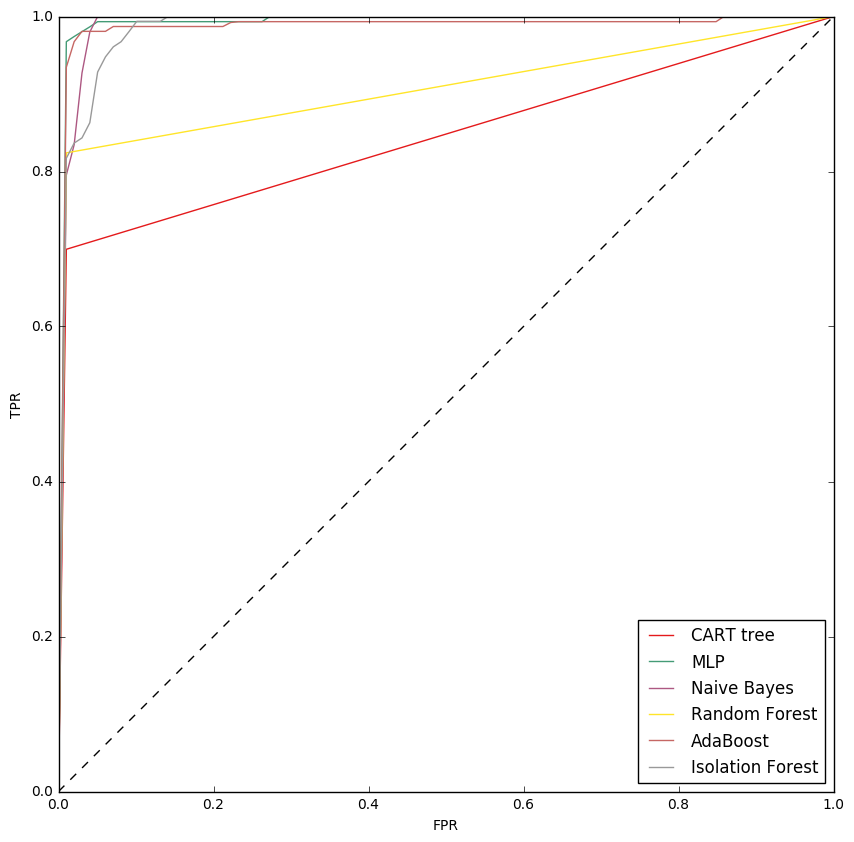

In [4]:
plt.rcParams['figure.figsize'] = 10,10

f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')

#add the line for just using an SNR cutoff 
#snr = X[:,0]
#fpr, tpr, thresholds = roc_curve(Y, snr, pos_label = 1)
#ax.plot(fpr,tpr, linestyle = '--', color = 'blue', label = 'SNR')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

CART tree PR Score: 0.631241049593 +/- 0.102394762129
MLP PR Score: 0.663727444486 +/- 0.116367709552
Naive Bayes PR Score: 0.556810653148 +/- 0.104729461763
Random Forest PR Score: 0.76073810167 +/- 0.111743097199
AdaBoost PR Score: 0.724375679138 +/- 0.130439180208
Isolation Forest PR Score: 0.511930623441 +/- 0.162976118351


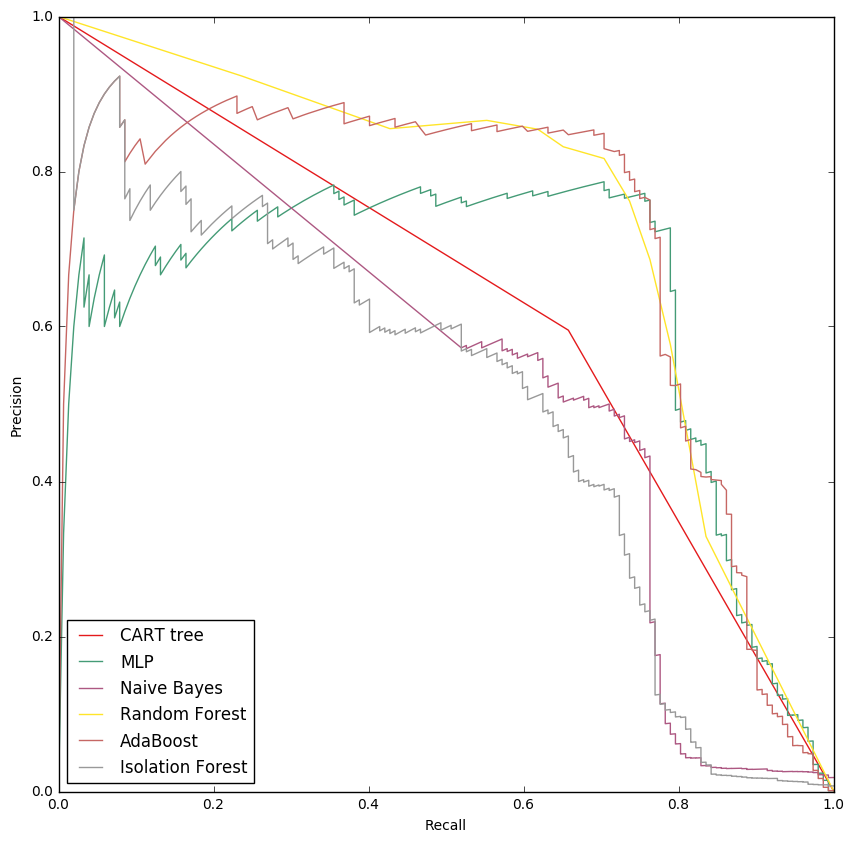

In [58]:
plt.rcParams['figure.figsize'] = 10,10

f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(classifiers, colors): 
    prscore_mean, prscore_std = mean_PR_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} PR Score: {} +/- {}".format(name, prscore_mean, prscore_std)

ax.legend(loc = 'lower left')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

This graph, the precision-recall curve, demonstrates a shortcoming off the isolation forest method: that it is less precise. This is almost certainly since, unlike supervised methods, it cannot learn that certain regions of data space do not contain fast radio bursts (see decision boundaries), and so returns a greater proportion of false positives. This should not be taken too seriously, since the precision is not insensitive to the dataset proportion. In particular, in practice the actual rate of true positives for fast radio bursts is unknown, the actual precision may be different. It is almost certainly much lower than the rate in this training set, for instance. However, it does highlight the behaviour of the isolation forest that it returns all outliers, not just those that look like frbs. For example, it is likely to return high snr signals even at very low dm. However, it would be easy to remove these manually with a simple threshold, which would increase the precision of the whole system consirably. 

%%TODO? plot pr for isolationforest + a cutoff

Isolation Forest + Cutoff PR Score: 0.565120961937 +/- 0.125012333088
Naive Bayes PR Score: 0.549266773823 +/- 0.121437860647
Random Forest PR Score: 0.750056647122 +/- 0.122850436914
AdaBoost PR Score: 0.748624263655 +/- 0.131537599124
Isolation Forest PR Score: 0.500951255606 +/- 0.144839608698


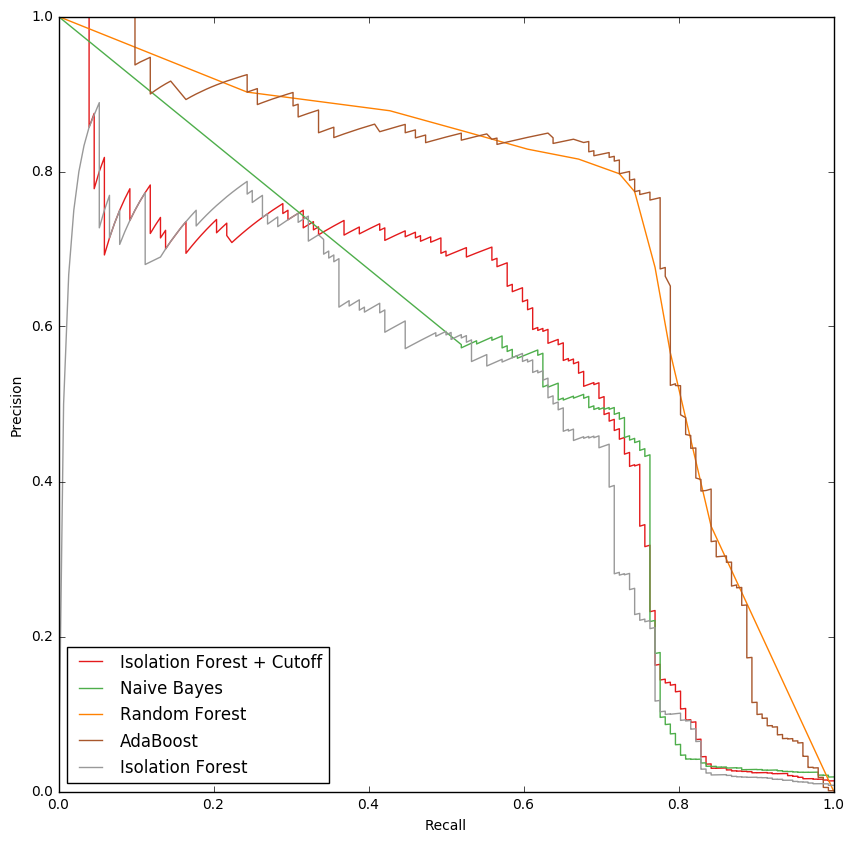

In [4]:
plt.rcParams['figure.figsize'] = 10,10

class IsolationTreeCutoff(IsolationTreeClassifier):
    def __init__(self,dm_cutoff = 500, max_samples = 8000, dm_index = 2):
        self.dm_index = dm_index 
        self.dm_cutoff = dm_cutoff
        self.iso_tree = IsolationTreeClassifier(max_samples = max_samples)
    def fit(self, X, Y):
        self.iso_tree.fit(X,Y)
    def decision_function(self, X):
        scores = self.iso_tree.decision_function(X)
        scores[X[:,self.dm_index] < self.dm_cutoff] = scores.min()
        return scores
    
f, ax = plt.subplots(1)

iso_list = [("Isolation Forest + Cutoff", IsolationTreeCutoff())] + classifiers


del iso_list[1:3]
del iso_list[5:7]
cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(iso_list))]

for (name, clf), col  in zip(iso_list, colors): 
    prscore_mean, prscore_std = mean_PR_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} PR Score: {} +/- {}".format(name, prscore_mean, prscore_std)

ax.legend(loc = 'lower left')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

Isolation Forest PR Score: 0.514603112344 +/- 0.117339785455
PCA Log Likelihood PR Score: 0.386635172964 +/- 0.113941241346
One Class SVM PR Score: 0.479237922712 +/- 0.134673462083
Elliptic Envelope PR Score: 0.000485937267388 +/- 1.24050171023e-05


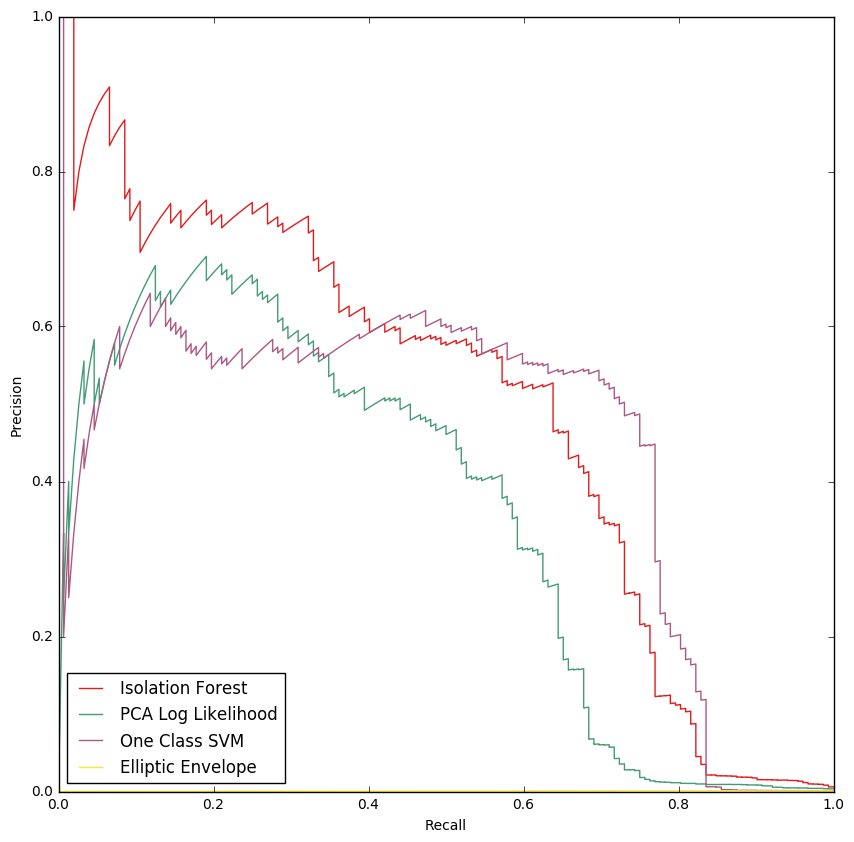

In [21]:
plt.rcParams['figure.figsize'] = 10,10

f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(unsupervised_classifiers, colors): 
    prscore_mean, prscore_std = mean_PR_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} PR Score: {} +/- {}".format(name, prscore_mean, prscore_std)

ax.legend(loc = 'lower left')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

(0.65761183952616287, 0.098873507581993411)

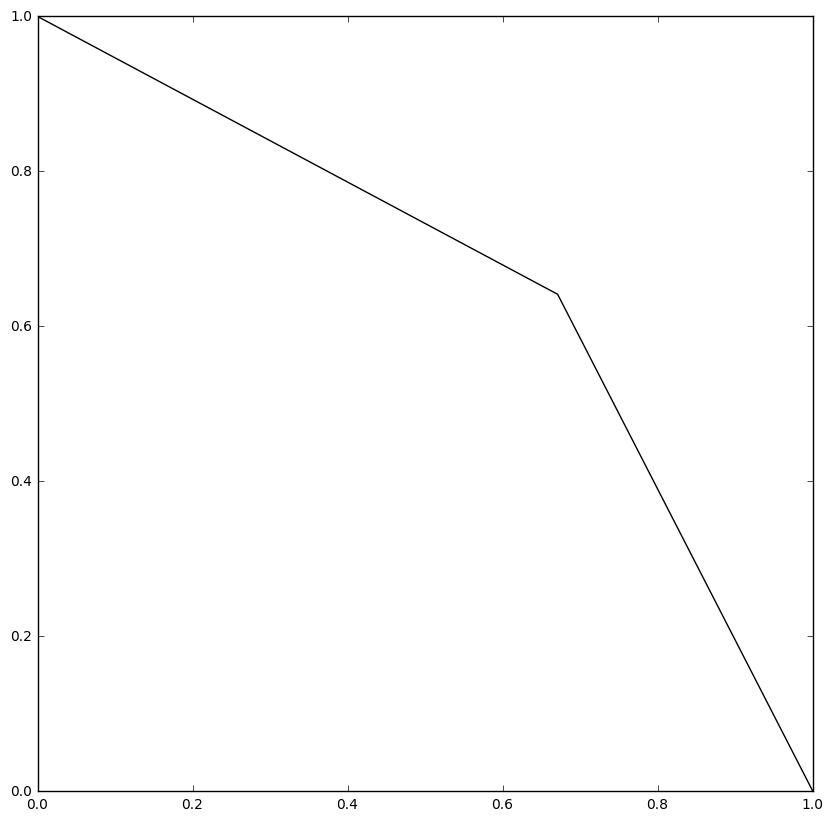

In [55]:
def plot_pr_curve_test(clf,X,Y):
    clf.fit(X, Y)
    scores = clf.decision_function(X)
    pr, rc, _ = precision_recall_curve(Y, scores)
    print pr 
    print rc
    plt.plot(pr,rc)
    


f, ax = plt.subplots(1)
mean_PR_curve(DecisionTreeClassifier(), X, Y, ax)

In [45]:
? interp

In [3]:
with open("frb_datasets/ninjector_snr_dm_w.dat") as f:
    data_file = [[float(field) for field in line.strip().split(' ')] for line in f]
    
all_data = np.array(data_file, dtype=np.float32)

#remove all frbs from the dataset: we only want to train the encoder on noise, in order to detect outliers 

X = all_data[:,:-1] #remove the class label 
Y = all_data[:,-1].astype(np.int) #class labels
#remove 0 dm (this is pretty conservative)
g0inds = X[:,1] > 0.
X = X[g0inds]
Y = Y[g0inds]

In [78]:
with open("frb_datasets/w_snr_dm_nn_score.dat") as f:
    data_file = [[float(field) for field in line.strip().split(' ')] for line in f]
old_data = np.array(data_file, dtype=np.float32)

old_x = old_data[:,:-2]
old_y = old_data[:,-1]
old_x.shape

(15377, 3)

In [75]:
old_y.sum()

70.0

In [72]:
(all_data[:,0] == np.inf).astype(np.int).sum()

0

In [74]:
Y.sum()

70

CART tree ROC Score: 0.806824570106 +/- 0.0588757846178
MLP ROC Score: 0.998950066138 +/- 0.00108391733053
Naive Bayes ROC Score: 0.991292576058 +/- 0.00848007407127
Random Forest ROC Score: 0.956708829365 +/- 0.049954031322
AdaBoost ROC Score: 0.993442046958 +/- 0.0173331404546
Isolation Forest ROC Score: 0.988450727513 +/- 0.0102070614099
PCA Classifier (n_components = 3) ROC Score: 0.956332671958 +/- 0.0315073340763
One Class SVM ROC Score: 0.965831679894 +/- 0.0474283088081


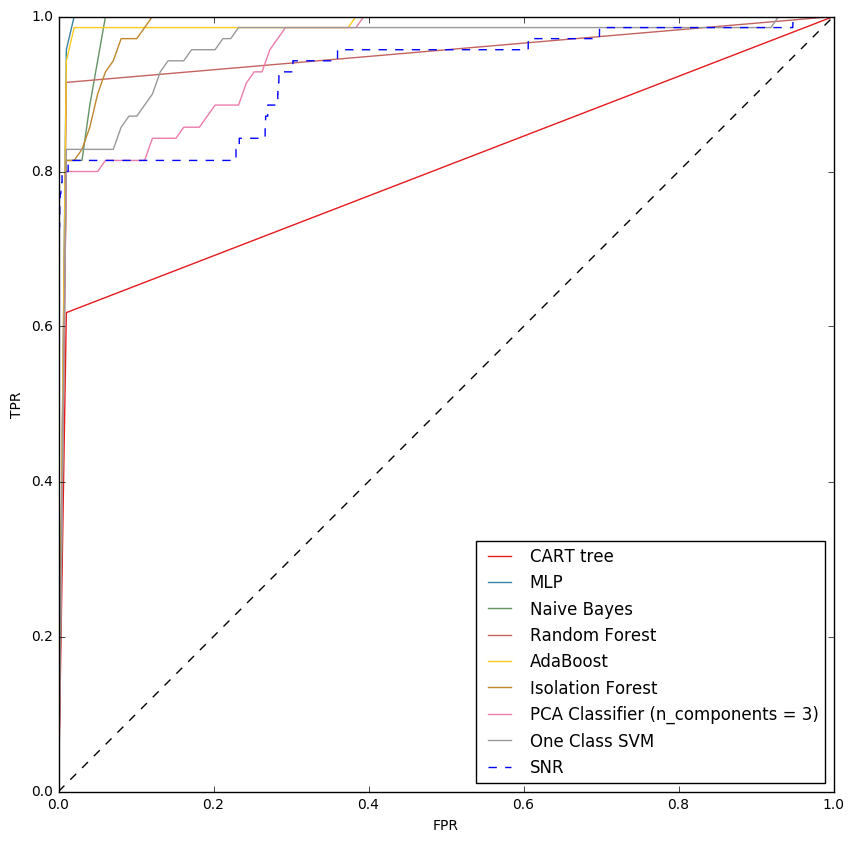

In [6]:
plt.rcParams['figure.figsize'] = 10,10

from matplotlib.cm import get_cmap
f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')

#add the line for just using an SNR cutoff 
snr = X[:,0]
fpr, tpr, thresholds = roc_curve(Y, snr, pos_label = 1)
ax.plot(fpr,tpr, linestyle = '--', color = 'blue', label = 'SNR')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

This compares a set of supervised classifiers with the semi-supervised approach in stratified cross validation by comparing their Reciever-Operating Characteristic curves (the true positive rate plotted against the false positive rate). The dotted line indicated equal true and false positive rates (which would be achieved by a classifier that guessed the labels randomly. 
This shows that the semi-supervised approach outperforms a simple decision tree and (perhaps suprisingly) random forest, normally a strong classifier, but is outperformed by naive bayes once TPR's above around 95% are expected, and is outperformed in general by adaboost and mlp. 
That supervised approaches outperform semi-supervised is probably to be expected: the advantage of the isolation forest is that it does not in fact require any positives during training. That it can still achieve similar classification performance to a fully supervised approach (which requires training data to avoid overfitting) is pretty good really.
It does indicate that in practice it might be desirable to gradually transition to a more supervised approach as more training data becomes avaliable. 

It's interesting that only isolation forest significantly outperforms an SNR cutoff.


CART tree ROC Score: 0.858013426245 +/- 0.0915603507119
MLP ROC Score: 0.999135979123 +/- 0.000759828062267
Naive Bayes ROC Score: 0.991393978843 +/- 0.00493279140925
SVM ROC Score: 0.986256773674 +/- 0.0230741621571
Random Forest ROC Score: 0.933546895643 +/- 0.0424318839801
AdaBoost ROC Score: 0.993882910253 +/- 0.0165604880673
Isolation Forest ROC Score: 0.988228319944 +/- 0.00732999720466
PCA Classifier (n_components = 3) ROC Score: 0.95676848482 +/- 0.0279366045659
One Class SVM ROC Score: 0.968670698439 +/- 0.0449972890877


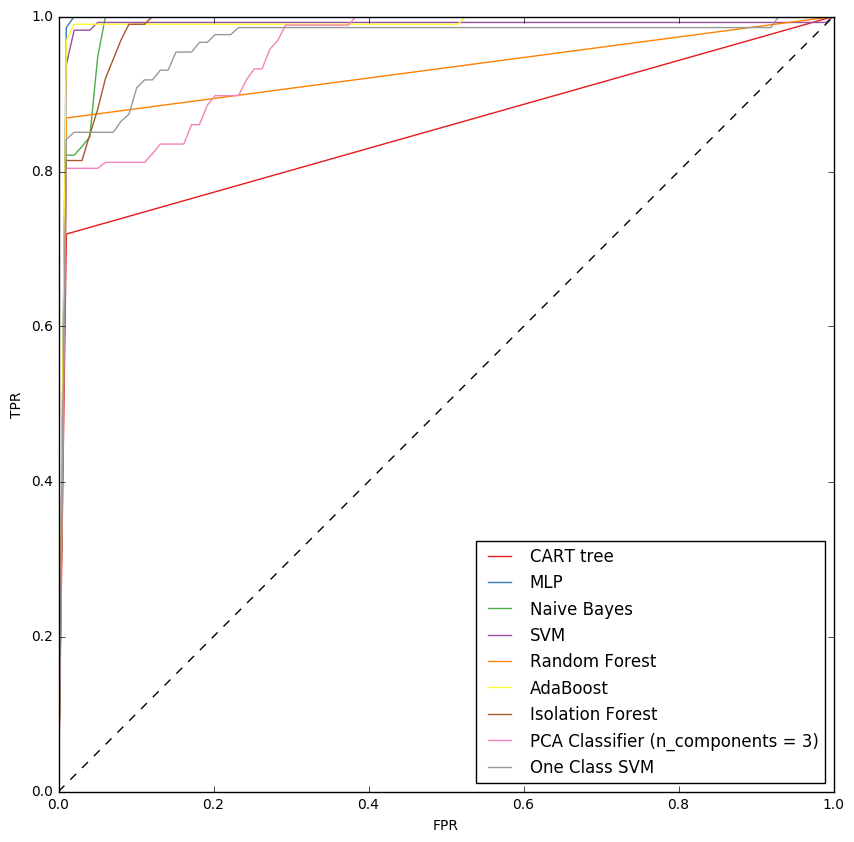

In [82]:
f, ax = plt.subplots(1)
for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name, stratified = False)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

Not doing stratifed cross val doesn't hurt the other classifiers as much as I expected: I suppose that the FRB rate is so low it is effectively the same. 


In [92]:
with open("frb_datasets/second_run_snr_dm_w.dat") as f:
    for line in f:
        line = line.strip().split(' ')
        try:
            fields = [float(field) for field in line]
        except:
            print line
    

In [93]:
#try on the new data
with open("frb_datasets/second_run_snr_dm_w.dat") as f:
    data_file = [[float(field) for field in line.strip().split(' ')] for line in f if line != ""]
    
all_data = np.array(data_file, dtype=np.float32)

#remove all frbs from the dataset: we only want to train the encoder on noise, in order to detect outliers 

X_second = all_data[:,:-1] #remove the class label 
Y_second = all_data[:,-1].astype(np.int) #class labels
#remove 0 dm (this is pretty conservative)
g0inds = X_second[:,1] > 0.
X_second = X_second[g0inds]
Y_second = Y_second[g0inds]



CART tree ROC Score: 0.835945505546 +/- 0.0690201004201
MLP ROC Score: 0.985776318626 +/- 0.0374488297852
Naive Bayes ROC Score: 0.992556394199 +/- 0.00591929668125
SVM ROC Score: 0.989491818716 +/- 0.0138310959657
Random Forest ROC Score: 0.90878457292 +/- 0.0579428773027
AdaBoost ROC Score: 0.983448906148 +/- 0.0328453271446
Isolation Forest ROC Score: 0.985884075605 +/- 0.0106926122765
PCA Classifier (n_components = 3) ROC Score: 0.964929077816 +/- 0.0245466460036
One Class SVM ROC Score: 0.929454100228 +/- 0.082490038955


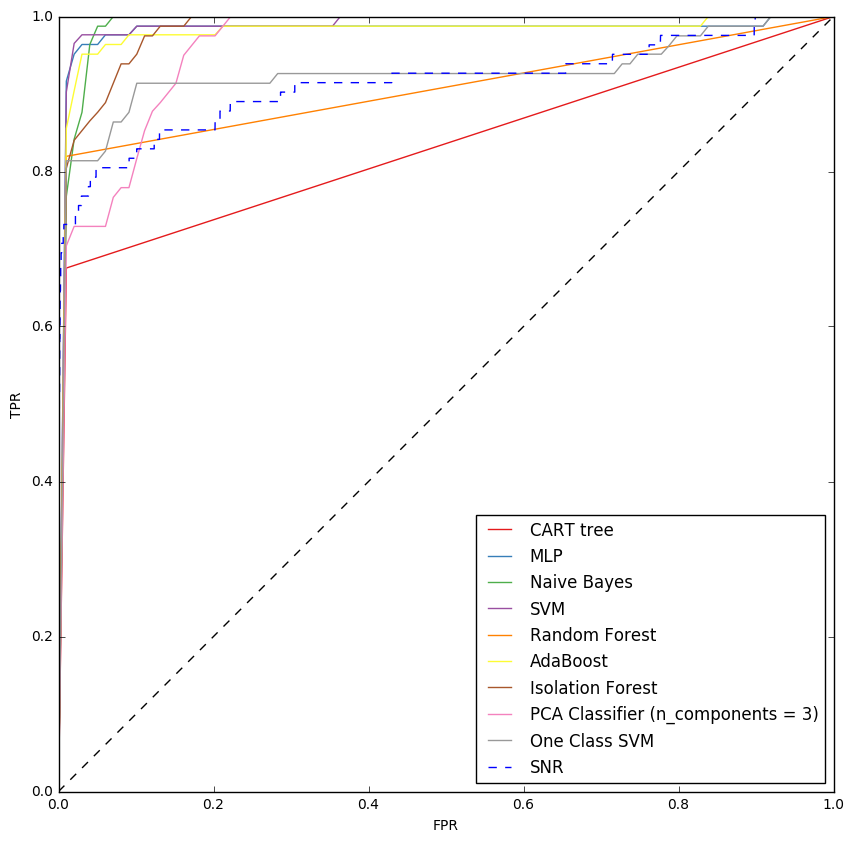

In [94]:
f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X_second, Y_second, ax,n_folds = 10, color = col, legend = name)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')

#add the line for just using an SNR cutoff 
snr = X_second[:,0]
fpr, tpr, thresholds = roc_curve(Y_second, snr, pos_label = 1)
ax.plot(fpr,tpr, linestyle = '--', color = 'blue', label = 'SNR')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

The PCA results suggest that the final field is not particularly useful.. try the other classifiers without it 

CART tree ROC Score: 0.835672792077 +/- 0.0759693924807
MLP ROC Score: 0.996214068392 +/- 0.00763346571421
Naive Bayes ROC Score: 0.994010041225 +/- 0.00268801639001
Random Forest ROC Score: 0.907475826532 +/- 0.0570572163668
AdaBoost ROC Score: 0.991865535758 +/- 0.0176020396831
Isolation Forest ROC Score: 0.983084762439 +/- 0.00914012434992
PCA Classifier (n_components = 3) ROC Score: 0.963024083283 +/- 0.0187049497592
One Class SVM ROC Score: 0.886353159637 +/- 0.0560923803871


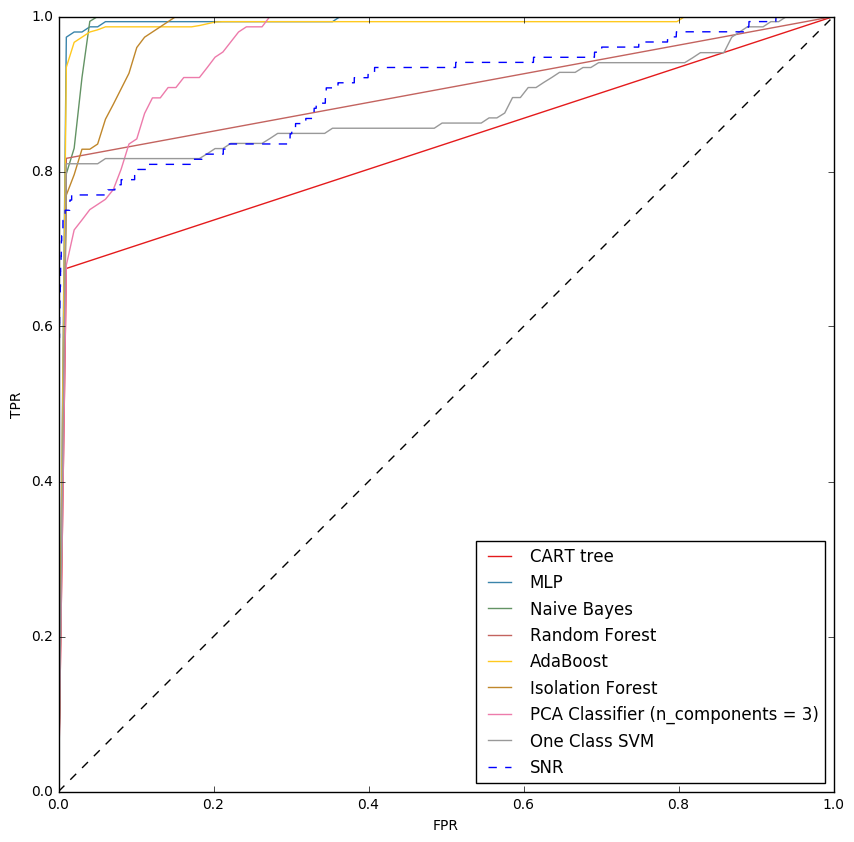

In [7]:
#try all data with some new features added again

with open("frb_datasets/all_data_snr_w_dm_grp_cands.dat") as f:
    data_file = [[float(field) for field in line.strip().split(' ')] for line in f if line != ""]
    
all_data = np.array(data_file, dtype=np.float32)

#remove all frbs from the dataset: we only want to train the encoder on noise, in order to detect outliers 

X = all_data[:,:-1] #remove the class label 
Y = all_data[:,-1].astype(np.int) #class labels
#remove 0 dm (this is pretty conservative)
g0inds = X[:,1] > 0.
X= X[g0inds]
Y = Y[g0inds]

from matplotlib.cm import get_cmap
f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')

#add the line for just using an SNR cutoff 
snr = X[:,0]
fpr, tpr, thresholds = roc_curve(Y, snr, pos_label = 1)
ax.plot(fpr,tpr, linestyle = '--', color = 'blue', label = 'SNR')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

CART tree ROC Score: 0.831747779409 +/- 0.053429051759
MLP ROC Score: 0.994759674383 +/- 0.0125350105671
Naive Bayes ROC Score: 0.993901496383 +/- 0.00273756045754
Random Forest ROC Score: 0.928108323266 +/- 0.0467123134743
AdaBoost ROC Score: 0.989310546043 +/- 0.0187860699091
Isolation Forest ROC Score: 0.989243304373 +/- 0.00488847705943
PCA Classifier (n_components = 3) ROC Score: 0.969432929585 +/- 0.0153248572605
One Class SVM ROC Score: 0.899106886518 +/- 0.060328876489


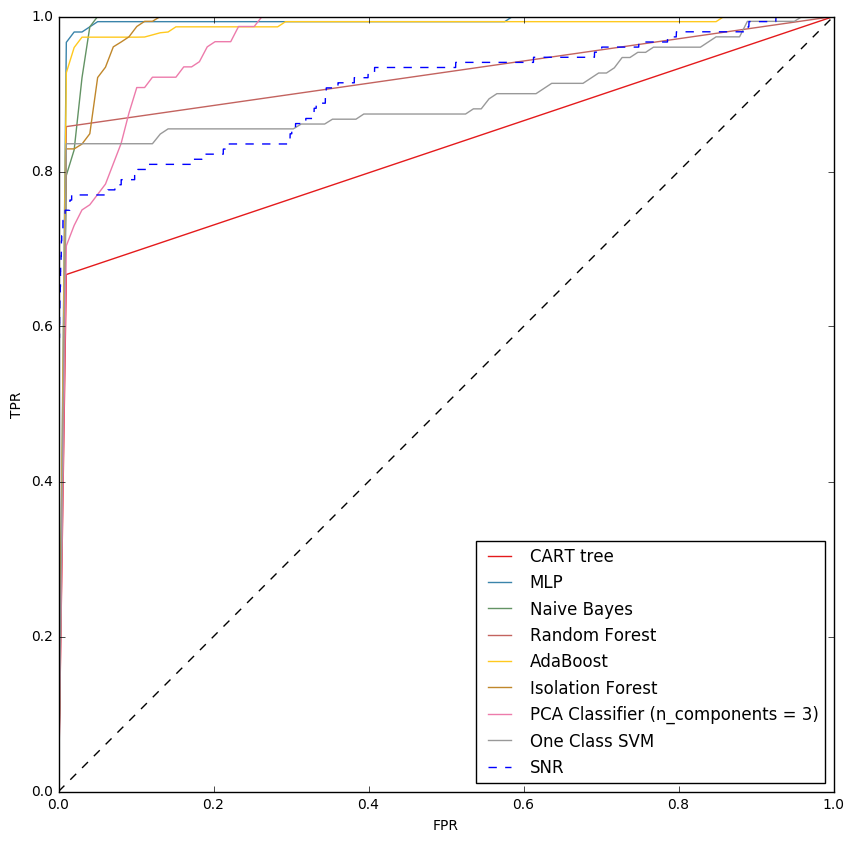

In [8]:
#try all data with the old features only (snr, w, dm)

with open("frb_datasets/all_data_snr_w_dm_grp_cands.dat") as f:
    data_file = [[float(field) for field in line.strip().split(' ')] for line in f if line != ""]
    
all_data = np.array(data_file, dtype=np.float32)

#remove all frbs from the dataset: we only want to train the encoder on noise, in order to detect outliers 

X = all_data[:,:-2] #remove the class label & grouped candidates to see if this has an effect
Y = all_data[:,-1].astype(np.int) #class labels
#remove 0 dm (this is pretty conservative)
g0inds = X[:,1] > 0.
X= X[g0inds]
Y = Y[g0inds]

from matplotlib.cm import get_cmap
f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')

#add the line for just using an SNR cutoff 
snr = X[:,0]
fpr, tpr, thresholds = roc_curve(Y, snr, pos_label = 1)
ax.plot(fpr,tpr, linestyle = '--', color = 'blue', label = 'SNR')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

In [29]:
!src/MICalc++/micalc frb_datasets/dm_w_grp_n_grp_t_snr_nn_var_widths_discrete.dat

--MI--
4 0.0126401
0 0.00904933
1 0.00491508
12 0.000314758
13 0.000297448
5 0.000289115
8 0.000250348
11 0.00024757
9 0.000246665
10 0.000225018
6 0.000221188
7 0.000214014
14 0.000206102
2 3.3381e-05
3 1.80954e-05
--JMI--
4 0.0126401
0 0.0166097
1 0.0285325
8 0.0274666
2 0.0279905
6 0.0282941
9 0.0287003
12 0.0288765
7 0.0292527
5 0.0296178
13 0.0299896
14 0.0301642
11 0.0304303
10 0.0305331
3 0.0295018
--HD--
1 0.9618
4 0.899261
0 0.882574
5 0.701875
2 0.695558
6 0.616897
3 0.592351
7 0.581696
12 0.573
13 0.572826
8 0.571224
9 0.567209
11 0.566789
10 0.566302
14 0.561349


In [32]:
X_less = X[:,0:-1]
X_less.shape

(15377, 3)

In [33]:
classifiers = []

classifiers.append(("CART_tree", DecisionTreeClassifier()))
classifiers.append(("MLP", Pipeline([('scaler', StandardScaler()), ('mlp',MLPClassifier())])))
classifiers.append(("Naive_Bayes", GaussianNB()))
classifiers.append(("Random_Forest", RandomForestClassifier()))
classifiers.append(("AdaBoost", AdaBoostClassifier()))
classifiers.append(("IsolationForestClassifier", IsolationTreeClassifier(max_samples=8000)))
classifiers.append(("PCA Classifier (n_components = 3)", 
                    Pipeline([('scaler', StandardScaler()), ('pca', PCA_Classifier(n_components = 3))])))
classifiers.append(("PCA Classifier (n_components = 2)", 
                    Pipeline([('scaler', StandardScaler()), ('pca', PCA_Classifier(n_components = 2))])))

CART_tree ROC Score: 0.820807933886 +/- 0.112651611168
MLP ROC Score: 0.997414583512 +/- 0.00242984959901
Naive_Bayes ROC Score: 0.985552881288 +/- 0.0113564790841
Random_Forest ROC Score: 0.942007872167 +/- 0.0454095099808
AdaBoost ROC Score: 0.995459937513 +/- 0.00559252617295
IsolationForestClassifier ROC Score: 0.977384791496 +/- 0.0226512102962
PCA Classifier (n_components = 3) ROC Score: 0.932117538502 +/- 0.0724207888391
PCA Classifier (n_components = 2) ROC Score: 0.931350484021 +/- 0.0796218351832


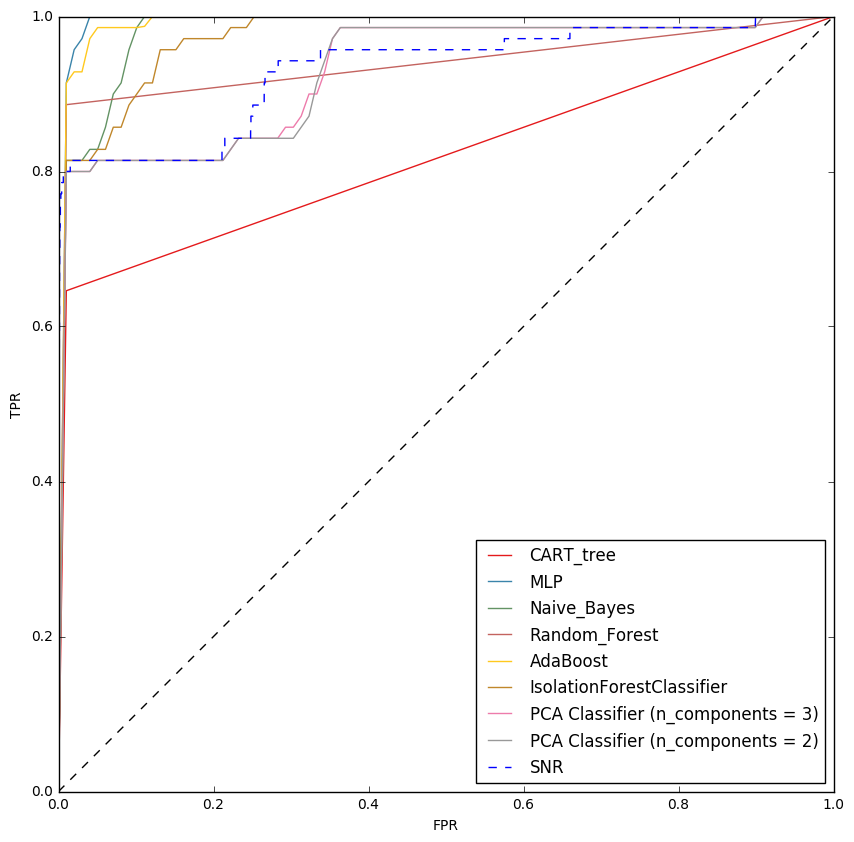

In [36]:
plt.rcParams['figure.figsize'] = 10,10

from matplotlib.cm import get_cmap
f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X_less, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')

#add the line for just using an SNR cutoff 
snr = X[:,1]
fpr, tpr, thresholds = roc_curve(Y, snr, pos_label = 1)
ax.plot(fpr,tpr, linestyle = '--', color = 'blue', label = 'SNR')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')